# Meshing RGI polygons

Here we'll show how to generate meshes out of polygons from the [Randolph Glacier Inventory](https://www.glims.org/RGI/) or RGI.
The RGI is a collection of high-resolution digitized outlines of every mountain glacier on earth.
There's a bit of preliminary data munging necessary to make things go well, which we'll demonstrate below.
The entire inventory is a gigantic file, so in order to make the search and processing faster we'll fetch only the regional segment for Alaska.

In [2]:
import icepack
rgi_filename = icepack.datasets.fetch_randolph_glacier_inventory("alaska")

This one shapefile contains many glacier outlines.
Rather than go through every entry manually, we'll use geopandas to search for the glacier we want by name.

In [3]:
import geopandas
dataframe = geopandas.read_file(rgi_filename)

We won't use this here, but it's good to see what's contained in each record.
The inventory includes not just the glacier outlines but their area, slope, aspect, and elevation.
So if you want to find (for example) the steepest glaciers in a particular region you can do that with a simple query.

In [4]:
dataframe.keys()

Index(['rgi_id', 'o1region', 'o2region', 'glims_id', 'anlys_id', 'subm_id',
       'src_date', 'cenlon', 'cenlat', 'utm_zone', 'area_km2', 'primeclass',
       'conn_lvl', 'surge_type', 'term_type', 'glac_name', 'is_rgi6',
       'termlon', 'termlat', 'zmin_m', 'zmax_m', 'zmed_m', 'zmean_m',
       'slope_deg', 'aspect_deg', 'aspect_sec', 'dem_source', 'lmax_m',
       'geometry'],
      dtype='object')

Here we'll look at Gulkana Glacier, which is in the Alaska Range.

In [5]:
entry = dataframe[dataframe["glac_name"] == "Wolverine Glacier"]

By default, the geometries in the RGI are stored in lat-lon coordinates, which isn't that useful to us.

In [6]:
outline_lat_lon = entry.geometry
outline_lat_lon.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The geopandas API includes functions that will estimate which Universal Transverse Mercator zone the polygon will be in.
In this case, Gulkana is in UTM zone 6.

In [7]:
utm_crs = outline_lat_lon.estimate_utm_crs()
utm_crs

<Projected CRS: EPSG:32606>
Name: WGS 84 / UTM zone 6N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 150°W and 144°W, northern hemisphere between equator and 84°N, onshore and offshore. United States (USA) - Alaska (AK).
- bounds: (-150.0, 0.0, -144.0, 84.0)
Coordinate Operation:
- name: UTM zone 6N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can then convert the lat/lon geometry to the new coordinate system.
Note that we don't necessarily need to use UTM zone 6.
For example, you might be working with a gridded data set of, say, ice thickness or velocity that happens to be in a different UTM zone.
In that case you should use whichever zone the rest of your data uses.

In [8]:
outline_utm = outline_lat_lon.to_crs(utm_crs)

Next, all the meshing routines in icepack expect a GeoJSON file.
The code below will convert the geopandas geometry into JSON, which has the undesirable effect of adding a superfluous Z coordinate.
We can then use the `map_tuples` function from the GeoJSON library to strip this out.

In [9]:
import geojson
outline_json = geojson.loads(outline_utm.to_json())
outline = geojson.utils.map_tuples(lambda x: x[:2], outline_json)

The icepack meshing module includes routines that will transform a GeoJSON data structure into the input format for a mesh generator like gmsh.

In [10]:
geometry = icepack.meshing.collection_to_geo(outline)
geo_filename = "wolverine.geo"
with open(geo_filename, "w") as geo_file:
    geo_file.write(geometry.get_code())

Next we'll call the mesh generator at the command line.

In [11]:
!gmsh -2 -v 0 wolverine.geo wolverine.msh

Finally, we'll load the result with Firedrake and visualize it.

In [12]:
import firedrake
mesh = firedrake.Mesh("wolverine.msh")

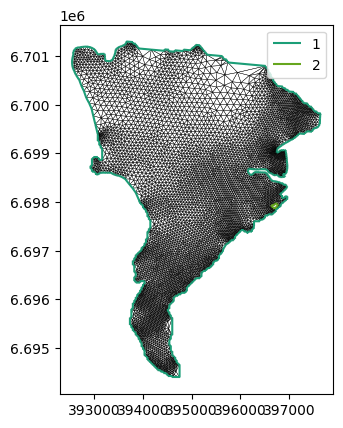

In [13]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_aspect("equal")
firedrake.triplot(mesh, axes=axes, interior_kw={"linewidth": 0.25})
axes.legend();

The legend shows the numeric IDs that are used to define each segment of the boundary.
You'll need these in the event that you need to define different boundary conditions on different segments, although for mountain glaciers it's usually enough to fix the velocity to zero at the boundaries.
Gulkana has lots of nunataks, so there are lots of segments.

You'll also notice that the mesh we get is very fine.
Using a resolution that high might not be necessary to get a result that's accurate enough and it will definitely be more expensive.
Depending on your use case, it might be worth doing some preliminary coarsening of the initial geometry.

# Modeling

In [76]:
# download the velocity data 
# !curl -O -C - https://its-live-data.s3.amazonaws.com/velocity_mosaic/landsat/v00.0/static/cog/ALA_G0120_0000_vx.tif
# !curl -O -C - https://its-live-data.s3.amazonaws.com/velocity_mosaic/landsat/v00.0/static/cog/ALA_G0120_0000_vy.tif
# download the thickness data
# ! curl -O -C - https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/315707/results_model_3.zip

In [14]:
import sys
import rasterio

In [36]:
# data path
path = "/uufs/chpc.utah.edu/common/home/u1215181/icepack/notebooks/\
real_case_practise/"

### Now, read thickness .tif file and interpolate thickness onto the glacier .shp
* Thickness data directory: \
/uufs/chpc.utah.edu/common/home/u1215181/icepack/notebooks/real_case_practise/results_model_3/RGI60-01/

In [55]:

tif_file = path + "results_model_3/RGI60-01/RGI60-01.09162_thickness.tif"
with rasterio.open(tif_file) as thickness:
    # read the image data
    tif_data = thickness.read(1)
    # get image metadata
    width = thickness.width
    height = thickness.height
    count = thickness.count
    crs = thickness.crs
    transform = thickness.transform
   
    Q = firedrake.FunctionSpace(mesh,'CG',2)
    h0 = icepack.interpolate(thickness, Q)
    
# print('Number of bands in the TIF file:', count)

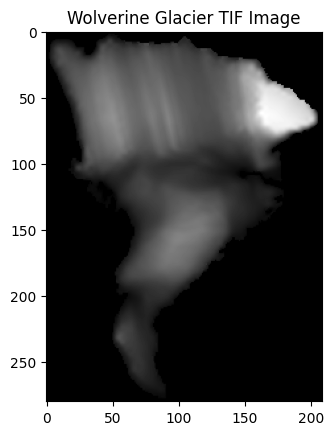

In [63]:
import matplotlib.pyplot as plt

plt.imshow(tif_data, cmap='gray')
plt.title("Wolverine Glacier TIF Image")
plt.show()



### For this case study we need an extra step for interpolating velocity field
Convert coordinate system for velocity data (vx, vy)
The origional velocity data are in a different coordiante system from the rest of the data. \
 You should reproject it to the CRS you want by doing another command-line call:
 [rio warp](https://rasterio.readthedocs.io/en/latest/api/rasterio.rio.warp.html) \
 type "rio warp --help" for more info 

"""\
vx_file = path + "ALA_G0120_0000_vx.tif"\
vy_file = path + "ALA_G0120_0000_vy.tif"\
!rio warp {vx_file} vx.tif --dst-crs EPSG:32606 --overwrite\
!rio warp {vy_file} vy.tif --dst-crs EPSG:32606 --overwrite\
"""

### Now, read converted velocity .tif file velocity onto the glacier .shp

In [89]:
vx_file = path + 'vx.tif'
vy_file = path + 'vy.tif'

with rasterio.open(vx_file) as vx, rasterio.open(vy_file) as vy:
    # Perform operations with the opened raster file
    print(f"shape of the vx and vy: \n {vx.shape}, {vy.shape}") 
    print(f"metadata for vx is \n {vx.meta}")
    print(f"metadata for vy is \n {vy.meta}")
    # interpolate velocity
    V = firedrake.VectorFunctionSpace(mesh, 'CG',2)
    u0 = icepack.interpolate((vx,vy), V)
    u0 = firedrake.interpolate(firedrake.as_vector((-u0[1],u0[0])),V)
    print(f"velocity field is {u0}")
   

shape of the vx and vy: 
 (19065, 24899), (19065, 24899)
metadata for vx is 
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 24899, 'height': 19065, 'count': 1, 'crs': CRS.from_epsg(32606), 'transform': Affine(114.52021404989334, 0.0, -144199.34994505392,
       0.0, -114.52021404989334, 7462916.989568143)}
metadata for vy is 
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 24899, 'height': 19065, 'count': 1, 'crs': CRS.from_epsg(32606), 'transform': Affine(114.52021404989334, 0.0, -144199.34994505392,
       0.0, -114.52021404989334, 7462916.989568143)}
velocity field is w⃗₁₃₉


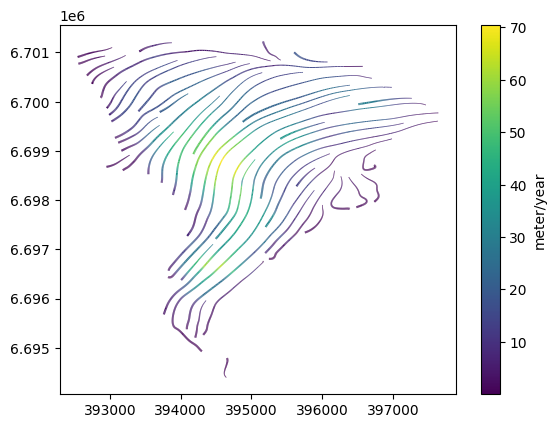

In [90]:
# create velocity streamlines
fig, axes = plt.subplots()
streamlines = firedrake.streamplot(u0, resolution=100, axes=axes) # 
fig.colorbar(streamlines, label='meter/year')

Set up the model in the same way as the synthetic ice shelf demo, but there are more doundary segments for which we need to apply Dirichlet conditions.

In [96]:
T = firedrake.Constant(260)
A = icepack.rate_factor(T)
model = icepack.models.ShallowIce()
opts = {"dirichlet_ids": [2, 4, 5, 6, 7, 8, 9], "tolerance": 1e-6}
solver = icepack.solvers.FlowSolver(model, **opts)

Next, we'll try to solve the shallow shelf equations to obtain the initial ice velocity.

In [97]:
try:
    u = solver.diagnostic_solve(
        velocity=u0, thickness=h0, fluidity=A
    )
except:
    print(f"Oh no, nonlinear solver did not converge!")

Oh no, nonlinear solver did not converge!


Now, we've got the first tast of how difficult working with real data can be. Why did the nonlinear solver fail to converge? The ice thickness map from BedMachine is fine enough to resolve pretty small-scale topography, even down to the depth of rifts in the ice shelf. Having such a high-resolution dataset means that the thickness can jump over a vary small distance. This could result in an unphysically large driving stress, which is the plot below.

In [98]:
from icepack.constants import(
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
)
from firedrake import grad

τ_d = firedrake.interpolate(
    -1e3 * ρ_I * g * (1 - ρ_I / ρ_W) * grad(h0**2), V
)

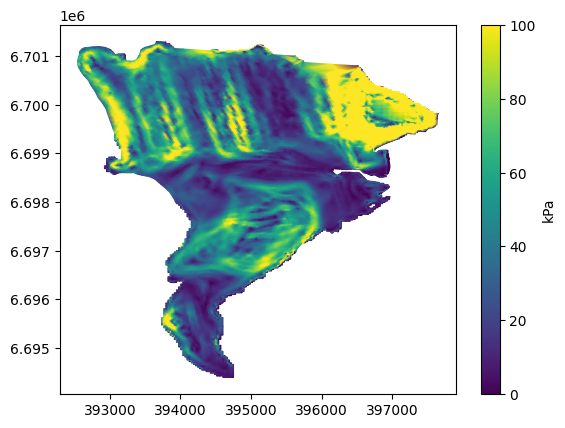

In [99]:
fig, axes = plt.subplots()
colors = firedrake.tripcolor(τ_d, vmin=0, vmax=100, axes=axes)
fig.colorbar(colors, label="kPa")

In many regions the driving stress exceed 100 kPa, which would be reasonable for a steep Greenland outlet glacier, not for a floating ice shelf. 

A quick hack around this would be to synthesize a new, smoother thickness field makes that mathches the direct obervations as well as possible. In other words, we want a field h that minimizes the following functional:

$J(h) =  $

In [88]:
from firedrake import assemble, inner, dx
h = h0.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J = 0.5 * (h - h0)**2 * dx + 0.5 * α**2 * inner(grad(h), grad(h)) * dx

F = firedrake.solve(F == 0, h)

NameError: name 'F' is not defined